Regression Task

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

In [ ]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/salary_prediction_data.csv')

In [ ]:
# Display basic information
print("Dataset Overview:\n", df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nColumn Names:\n", df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null   object 
 4   Age         1000 non-null   int64  
 5   Gender      1000 non-null   object 
 6   Salary      1000 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB
Dataset Overview:
 None

Summary Statistics:
         Experience          Age         Salary
count  1000.000000  1000.000000    1000.000000
mean     14.771000    42.377000  105558.404239
std       8.341111    13.609412   28256.972075
min       1.000000    20.000000   33510.510669
25%       7.000000    30.000000   85032.141517
50%      15.000000    43.000000  104314.518315
75%      22.000000    55.000000  126804.047524
max      29.000000    64.000000  193016.6

In [ ]:
df.isnull().sum()


,0
Education,0
Experience,0
Location,0
Job_Title,0
Age,0
Gender,0
Salary,0


In [ ]:
#Map "Male" to 1 and "Female" to 0
df['Gender'] = df ['Gender'].map({'Male': 1, 'Female': 0})

#Ensure the 'Gender' column is numeric (in case it has non-numeric data)
df['Gender'] = df['Gender'].fillna(0)

#Ensure the 'Gender' column is of integer type
df['Gender'] = df['Gender'].astype(int)

print(df['Gender'].head())

0    1
1    1
2    0
3    1
4    0
Name: Gender, dtype: int64


In [ ]:
#Mapping months to numeric values (e.g., Jan = 1, Feb = 2, ..., Dec = 12)
job_mapping = {'Director': 1, 'Manager': 2, 'Analyst': 3, 'Engineer': 4}
df['Job_Title'] = df['Job_Title'].map(job_mapping)

edu_mapping = {'High School': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4, }
df['Education'] =df['Education'].map(edu_mapping)
#Display the first few rows of the DataFrame to check
(df.head())

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,1,8,Urban,2,63,1,84620.053665
1,4,11,Suburban,1,59,1,142591.255894
2,2,28,Suburban,2,61,0,97800.255404
3,1,29,Rural,1,45,1,96834.671282
4,4,25,Urban,3,26,0,132157.786175


In [ ]:
#Calculate the IQR for each numeric column
numeric_cols = df.select_dtypes(include=np.number).columns
outliers_count = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers for the current column
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_count[col] = len(outliers)


#Print the number of outliers for each column
for col, count in outliers_count.items():
    print(f"Number of outliers in column '{col}': {count}")

#Total number of outliers across all numeric columns
total_outliers = sum(outliers_count.values())
print(f"\nTotal number of outliers across all numeric columns: {total_outliers}")

Number of outliers in column 'Education': 0
Number of outliers in column 'Experience': 0
Number of outliers in column 'Job_Title': 0
Number of outliers in column 'Age': 0
Number of outliers in column 'Gender': 0
Number of outliers in column 'Salary': 1

Total number of outliers across all numeric columns: 1


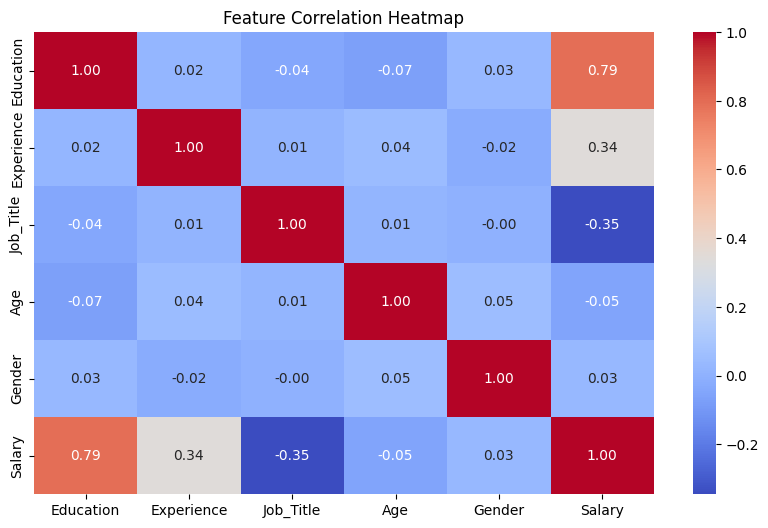

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

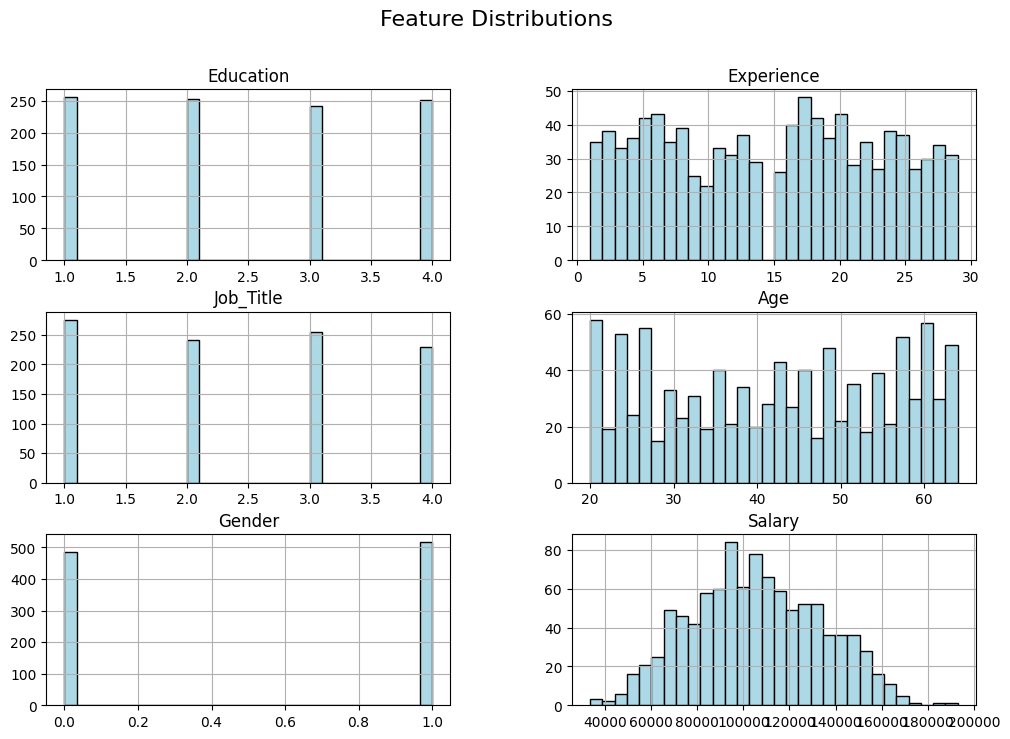

In [ ]:
# Feature Distributions
df.hist(figsize=(12, 8), bins=30, color='lightblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

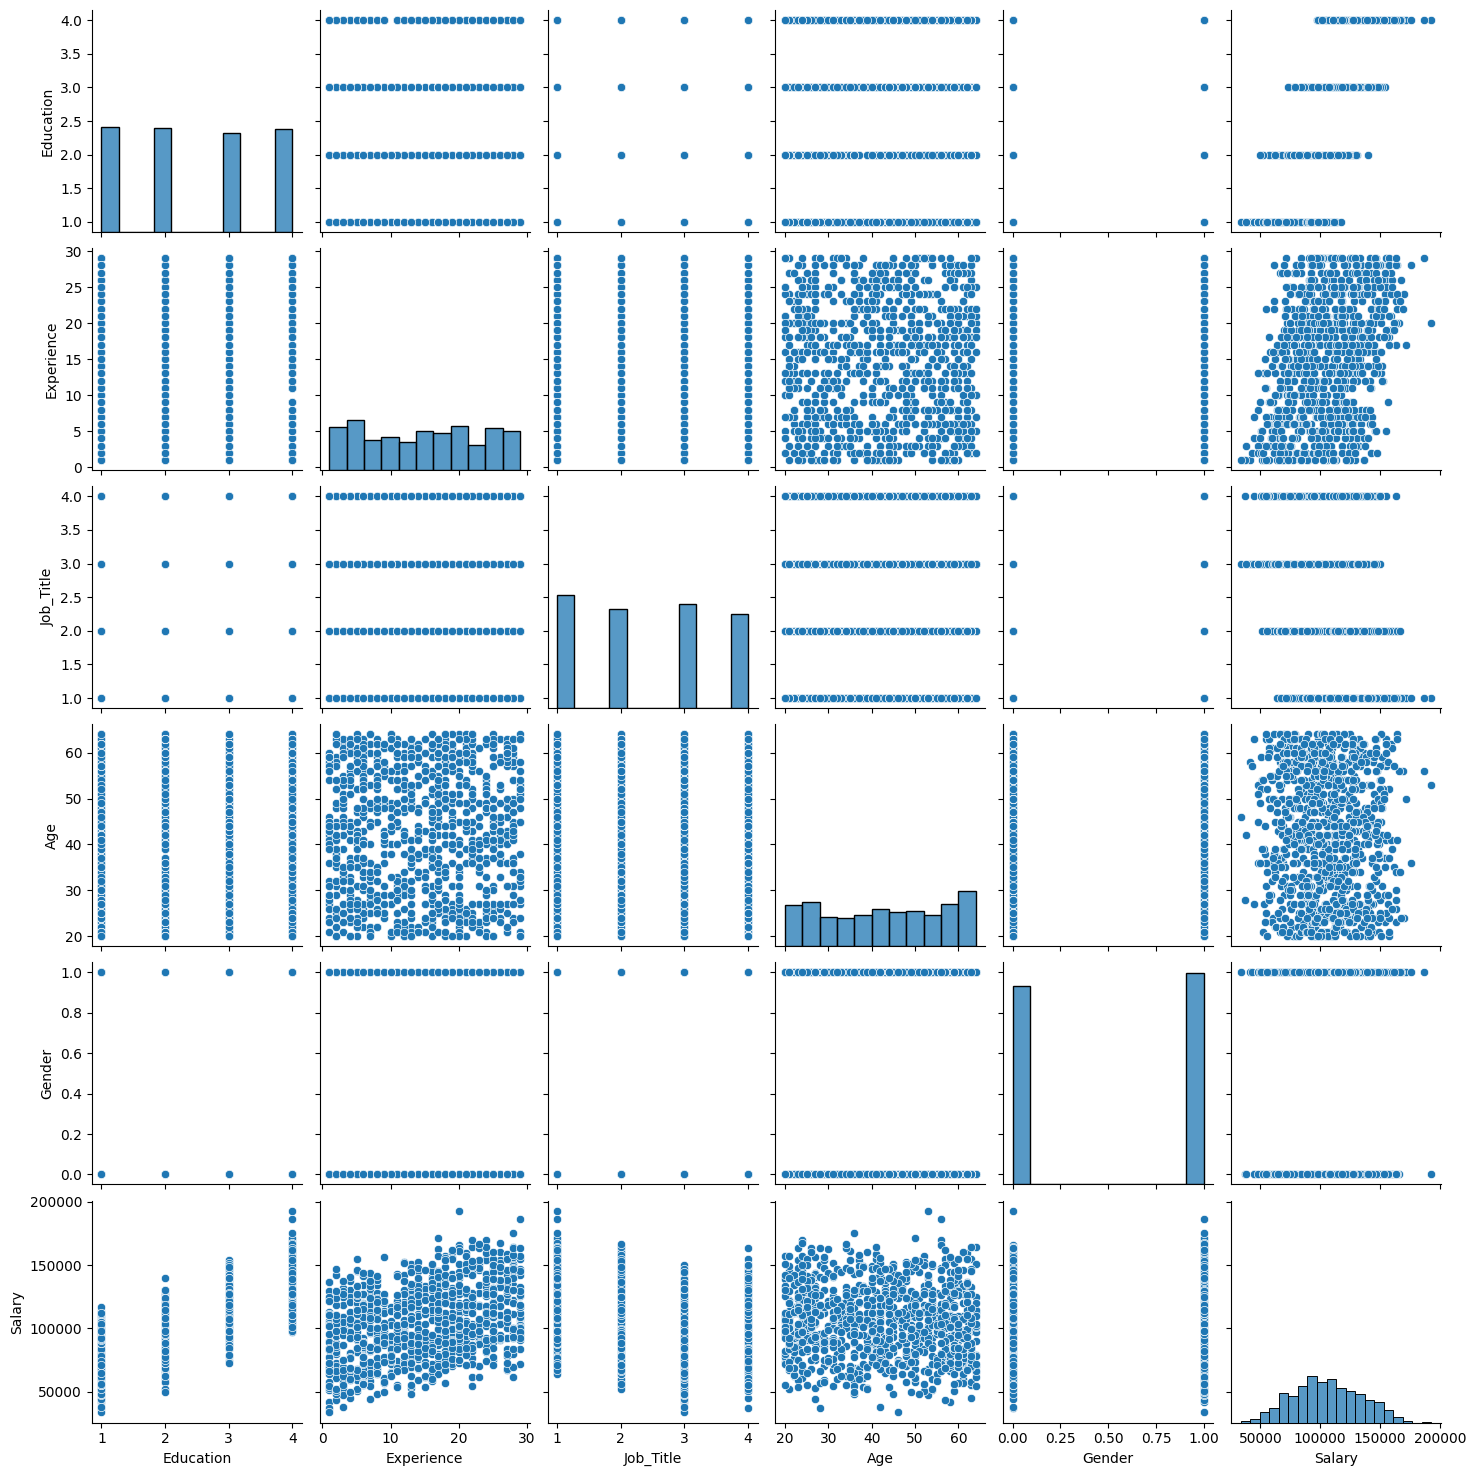

In [ ]:
# Pairplot to explore relationships
sns.pairplot(df)
plt.show()

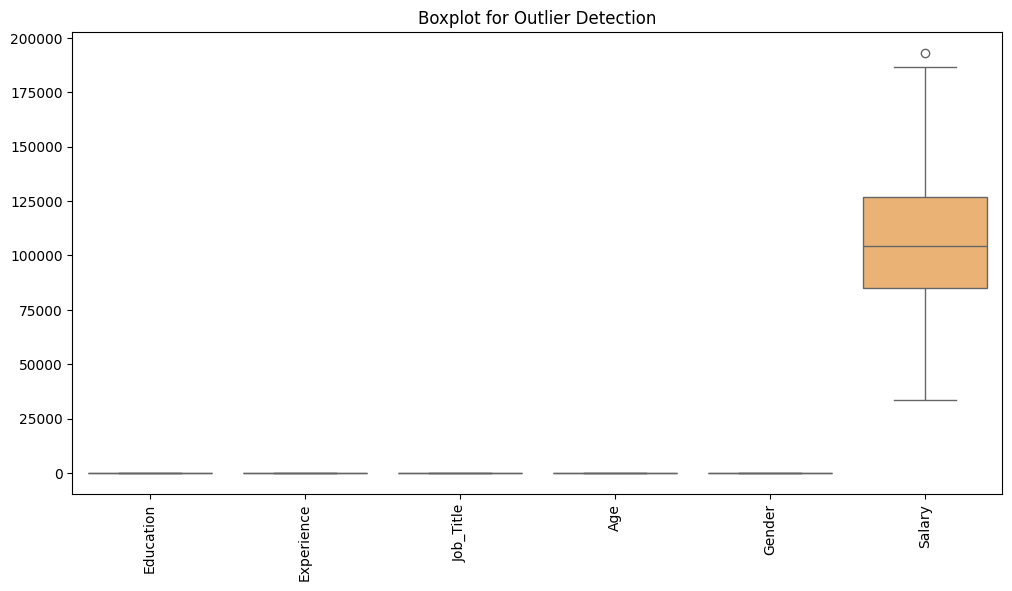

In [ ]:
# Boxplots for Outlier Detection
plt.figure(figsize=(12,6))
sns.boxplot(data=df, palette="Set3")
plt.xticks(rotation=90)
plt.title("Boxplot for Outlier Detection")
plt.show()

In [ ]:
# Choosing an appropriate target column
target_column = 'Salary'

In [ ]:
#Data Preprocessing
# Handle missing values
df.dropna(inplace=True)

In [ ]:
# Convert categorical columns to numeric if necessary
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Splitting dataset into features and target variable
X = df.drop(columns=[target_column])
y = df[target_column]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Build Linear Regression from Scratch
def linear_regression(X, y, alpha=0.01, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        predictions = X @ theta
        errors = predictions - y
        theta -= (alpha/m) * (X.T @ errors)
    return theta

X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta = linear_regression(X_train_bias, y_train)

def predict(X, theta):
    return X @ theta

y_pred_custom = predict(np.c_[np.ones((X_test.shape[0], 1)), X_test], theta)
print("Custom Linear Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_custom))
print("R2 Score:", r2_score(y_test, y_pred_custom))

Custom Linear Regression Performance:
MSE: 137505193.4250966
R2 Score: 0.8315974018226014


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[name] = {"MSE": mse, "R2 Score": r2}
    print(f"\n{name} Performance:")
    print("MSE:", mse)
    print("R2 Score:", r2)


Linear Regression Performance:
MSE: 137491309.55534402
R2 Score: 0.8316144053966545

Ridge Regression Performance:
MSE: 137410846.4465776
R2 Score: 0.8317129485588157

Lasso Regression Performance:
MSE: 137480738.1922798
R2 Score: 0.8316273521440607

Decision Tree Performance:
MSE: 204008488.55086616
R2 Score: 0.7501508221874945

Random Forest Performance:
MSE: 130971692.45238148
R2 Score: 0.8395989798837176


In [ ]:
# Hyperparameter Optimization using GridSearchCV
param_grid = {
    'Ridge Regression': {'alpha': [0.1, 1, 10]},
    'Lasso Regression': {'alpha': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]}
}

best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"\nBest parameters for {name}: {grid_search.best_params_}")


Best parameters for Ridge Regression: {'alpha': 1}

Best parameters for Lasso Regression: {'alpha': 10}

Best parameters for Decision Tree: {'max_depth': 5}

Best parameters for Random Forest: {'n_estimators': 100}


In [ ]:
# Feature Selection using Recursive Feature Elimination (RFE)
rfe = RFE(LinearRegression(), n_features_to_select=5)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("\nSelected Features:", selected_features)


Selected Features: Index(['Education', 'Experience', 'Location', 'Job_Title', 'Age'], dtype='object')


In [ ]:
# Final Model Evaluation
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[name] = {"MSE": mse, "R2 Score": r2}
    print(f"\nFinal {name} Model Performance:")
    print("MSE:", mse)
    print("R2 Score:", r2)


Final Ridge Regression Model Performance:
MSE: 137410846.4465776
R2 Score: 0.8317129485588157

Final Lasso Regression Model Performance:
MSE: 137386601.79048657
R2 Score: 0.8317426409869775

Final Decision Tree Model Performance:
MSE: 136206676.26461047
R2 Score: 0.8331876956737418

Final Random Forest Model Performance:
MSE: 128377194.60480404
R2 Score: 0.842776461167257


In [ ]:
# Conclusion
print("\nConclusion: Model Performance Summary")
for name, results in model_results.items():
    print(f"{name}: MSE = {results['MSE']}, R2 Score = {results['R2 Score']}")

best_model = max(best_models, key=lambda name: model_results[name]["R2 Score"])
print(f"\nThe best performing model based on R2 Score is: {best_model}")


Conclusion: Model Performance Summary
Linear Regression: MSE = 137491309.55534402, R2 Score = 0.8316144053966545
Ridge Regression: MSE = 137410846.4465776, R2 Score = 0.8317129485588157
Lasso Regression: MSE = 137386601.79048657, R2 Score = 0.8317426409869775
Decision Tree: MSE = 136206676.26461047, R2 Score = 0.8331876956737418
Random Forest: MSE = 128377194.60480404, R2 Score = 0.842776461167257

The best performing model based on R2 Score is: Random Forest
